# Ajuste del espectro con chi-cuadrado (no-lineal)

<ol>
<li>Errores tomados de los datos</li>
<li>Errores tomados del ajuste</li>
</ol>

In [1]:
%matplotlib notebook

In [2]:
import math
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
from scipy.stats import chi2
from scipy.optimize import curve_fit
from scipy.optimize import minimize

## Datos

Datos bineados en $x = log_{10}(E/eV)$, y = número de eventos en el bin

In [3]:
xdata = np.linspace(18.45, 20.45, 21)
ydata = np.array([13023, 7711, 4478, 3159, 2162, 1483, 1052, 699, 451, 323, 200, 110, 43, 28, 23, 5, 2, 0, 1, 0, 0])

In [4]:
ndatos = len(xdata)
ndatos

21

<IPython.core.display.Javascript object>


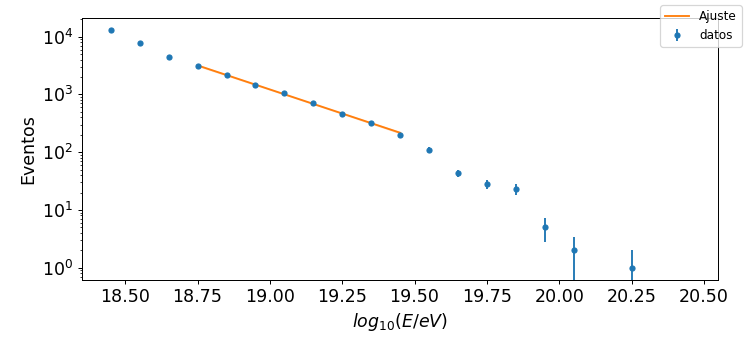

<ErrorbarContainer object of 3 artists>

In [5]:
fig1, ax1 = plt.subplots(figsize=(5,3))
ax1.set_xlabel('$log_{10}(E/eV)$')
ax1.set_ylabel('Eventos')
ax1.set_yscale("log")
ysigma = np.sqrt(ydata)
ax1.errorbar(xdata, ydata, ysigma,ls='none', marker='o', ms=4, label='datos')

## Modelo

In [6]:
def modelo(x, theta):
    return np.power(10, theta[0]-theta[1]*(x-19) ) 

## Función de costo

In [7]:
def funcion_costo(theta, xdata, ydata):
        costo = np.zeros_like(theta[0])
        for (x1, y1) in zip(xdata, ydata):
            mu1 = modelo(x1, theta)
            residuo = y1 - mu1
            costo += residuo**2 / y1     # errores tomados de los datos
#            costo += residuo**2 / mu1       # errores tomados del ajuste
        return costo

In [8]:
xfit, yfit = xdata[3:11], ydata[3:11]

In [9]:
xfit

array([18.75, 18.85, 18.95, 19.05, 19.15, 19.25, 19.35, 19.45])

In [10]:
yfit

array([3159, 2162, 1483, 1052,  699,  451,  323,  200])

In [11]:
J = lambda theta: funcion_costo(theta, xfit, yfit)  

## Minimización

In [12]:
res = minimize(J, x0=(3, 2))
res

      fun: 4.508157233047195
 hess_inv: array([[ 1.15563295e-05, -2.10936802e-05],
       [-2.10936802e-05,  2.78824663e-04]])
      jac: array([4.73976135e-04, 8.46385956e-06])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 142
      nit: 7
     njev: 44
   status: 2
  success: False
        x: array([3.08622272, 1.66648429])

## Dibujar ajuste

In [13]:
x = np.linspace( xfit.min(), xfit.max(), 256)
mu_est = modelo(x, res.x)
ax1.plot(x, mu_est, label='Ajuste')
fig1.legend()
fig1.savefig('espectro.svg')

In [14]:
theta_est = res.x
cova = 2*res.hess_inv
error = np.sqrt( np.diagonal(cova) )
rho = cova[0][1]/(error[0]*error[1])
print(f'a = {theta_est[0]:.3f} ± {error[0]:.3f}')
print(f'b = {theta_est[1]:.3f} ± {error[1]:.3f}')
print(f'ρ = {rho:.2f}')

a = 3.086 ± 0.005
b = 1.666 ± 0.024
ρ = -0.37


## Bondad del ajuste

In [15]:
chi2_min = res.fun
ndof = len(xfit) - len(theta_est)
pvalor = chi2.sf(chi2_min, ndof)
print(f'χ²min = {chi2_min:.2f}')
print(f'ndof = {ndof}')
print(f'pvalor = {pvalor*100:.1f}%')

χ²min = 4.51
ndof = 6
pvalor = 60.8%


## Errores gráficos

In [16]:
theta1 = np.linspace(theta_est[0]-4*error[0] , theta_est[0]+4*error[0], 100)
theta2 = np.linspace(theta_est[1]-4*error[1] , theta_est[1]+4*error[1], 100)
theta1, theta2 = np.meshgrid(theta1, theta2)
theta = np.array([theta1, theta2])
z = J(theta)

<IPython.core.display.Javascript object>


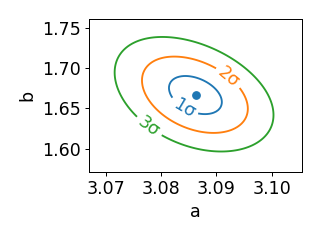

Text(0, 0.5, 'b')

In [17]:
fig2, ax2 = plt.subplots()
ax2.set_xlabel('a')
ax2.set_ylabel('b')

In [18]:
ax2.plot(*theta_est, 'o')

In [19]:
levels = chi2_min + np.array([1, 4, 9]) 

contour = ax2.contour(theta1, theta2, z, levels, colors=['tab:blue', 'tab:orange', 'tab:green'])

fmt = {}
strs = ['1σ', '2σ', '3σ']
for l, s in zip(contour.levels, strs):
    fmt[l] = s
ax2.clabel(contour, fmt=fmt)

<a list of 3 text.Text objects>

## Banda de error

In [20]:
grad_theta1 = math.log(10) * mu_est 
grad_theta2 = (x-19) * math.log(10) * mu_est 
grad = np.column_stack( (grad_theta1, grad_theta2) )
var_mu_est = np.einsum("ki,ij,kj->k", grad, cova, grad)
sigma_mu_est = np.sqrt(var_mu_est)

La banda de error no se distingue en la figura (sigma_mu_est/mu_est ~ 2%)

In [27]:
mu_est

array([3183.05242115, 3149.69954885, 3116.69615684, 3084.03858318,
       3051.72320429, 3019.74643455, 2988.10472594, 2956.79456759,
       2925.81248543, 2895.15504179, 2864.81883503, 2834.80049913,
       2805.09670336, 2775.70415188, 2746.6195834 , 2717.83977079,
       2689.36152073, 2661.18167337, 2633.29710196, 2605.70471254,
       2578.40144353, 2551.38426545, 2524.65018058, 2498.19622257,
       2472.0194562 , 2446.11697696, 2420.48591081, 2395.12341381,
       2370.02667182, 2345.19290019, 2320.61934343, 2296.30327496,
       2272.24199674, 2248.43283902, 2224.87315999, 2201.56034557,
       2178.49180904, 2155.66499078, 2133.07735802, 2110.7264045 ,
       2088.60965023, 2066.72464121, 2045.06894915, 2023.64017121,
       2002.43592972, 1981.45387193, 1960.69166974, 1940.14701944,
       1919.81764146, 1899.70128013, 1879.7957034 , 1860.09870262,
       1840.60809226, 1821.32170971, 1802.23741503, 1783.35309068,
       1764.66664131, 1746.17599354, 1727.87909572, 1709.77391

In [26]:
grad_theta1

array([7329.24905516, 7252.45122859, 7176.45811014, 7101.26126785,
       7026.85235813, 6953.22312482, 6880.36539825, 6808.27109438,
       6736.93221385, 6666.34084114, 6596.48914366, 6527.3693709 ,
       6458.97385356, 6391.29500269, 6324.32530887, 6258.05734136,
       6192.4837473 , 6127.59725085, 6063.39065241, 5999.85682784,
       5936.98872762, 5874.77937613, 5813.22187082, 5752.30938147,
       5692.03514943, 5632.39248687, 5573.37477604, 5514.97546853,
       5457.18808453, 5400.00621216, 5343.4235067 , 5287.43368992,
       5232.03054938, 5177.20793772, 5122.959772  , 5069.28003304,
       5016.1627647 , 4963.60207327, 4911.59212678, 4860.12715438,
       4809.2014457 , 4758.80935017, 4708.94527646, 4659.60369181,
       4610.77912145, 4562.46614796, 4514.65941069, 4467.35360517,
       4420.5434825 , 4374.22384878, 4328.38956453, 4283.03554414,
       4238.15675528, 4193.74821833, 4149.80500588, 4106.32224213,
       4063.29510238, 4020.71881248, 3978.5886483 , 3936.89993

In [23]:
ax1.fill_between(x, mu_est-sigma_mu_est, mu_est+sigma_mu_est, color='tab:orange', alpha=0.2)